In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('./preprocess/filter3.csv')

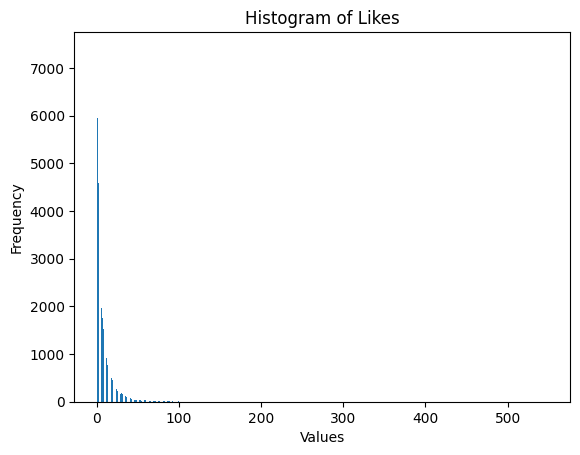

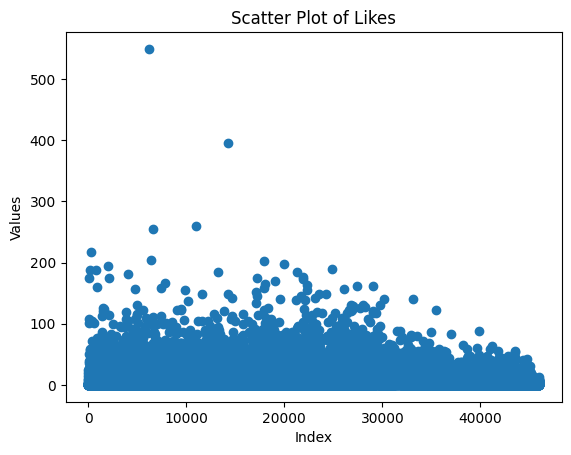

In [2]:
import matplotlib.pyplot as plt

# Plot histogram of Column2
plt.hist(df['Likes'], bins='auto')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Likes')
plt.show()

# Create scatter plot of Column2
plt.scatter(range(len(df['Likes'])), df['Likes'])
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Scatter Plot of Likes')
plt.show()

Text(0.5, 1.0, 'No. of words in Message')

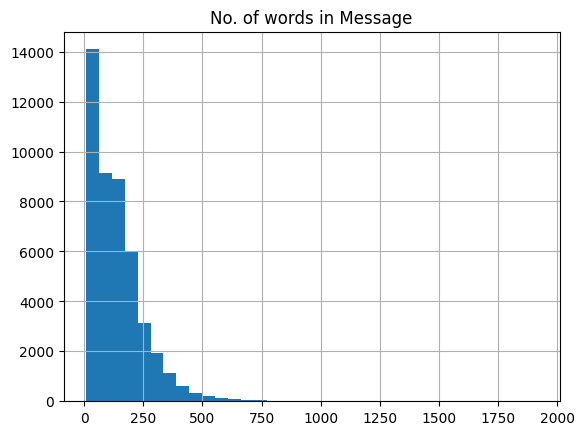

In [3]:
df['qLen'] = df['Message'].apply(lambda x : len(x.split(" ")))
df['qLen'].hist(bins=35)
plt.title("No. of words in Message")

In [4]:
import torch
from transformers import AutoModel, AutoTokenizer

# model_name = 'distilbert-base-uncased'
model_name = 'vinai/phobert-base-v2'

phobert = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


Some weights of the model checkpoint at vinai/phobert-base-v2 were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens

In [5]:
keyword = "Thủ tướng: Thúc đẩy hợp tác trong lĩnh vực Việt Nam có lợi ích chiến lược"
tokens = tokenizer.tokenize(keyword)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('tokens', tokens)
print('token_ids', token_ids)

encodeText = tokenizer.encode(keyword)
print('encodeText', encodeText, torch.tensor([encodeText]))
embedding = phobert(torch.tensor([encodeText]))
print('embedding', embedding)


tokens ['Thủ', 'tướ@@', 'ng@@', ':', 'Thúc', 'đẩy', 'hợp', 'tác', 'trong', 'lĩnh', 'vực', 'Việt', 'Nam', 'có', 'lợi', 'ích', 'chiến', 'lược']
token_ids [11639, 42594, 1701, 27, 50483, 1172, 2288, 18116, 12, 7362, 5191, 350, 590, 10, 1596, 6902, 2856, 8536]
encodeText [0, 11639, 42594, 1701, 27, 50483, 1172, 2288, 18116, 12, 7362, 5191, 350, 590, 10, 1596, 6902, 2856, 8536, 2] tensor([[    0, 11639, 42594,  1701,    27, 50483,  1172,  2288, 18116,    12,
          7362,  5191,   350,   590,    10,  1596,  6902,  2856,  8536,     2]])
embedding BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0322,  1.0349, -0.1750,  ..., -0.0736,  0.4842,  0.3704],
         [ 0.0719,  0.2565,  0.0509,  ...,  0.1531,  0.1359,  0.2347],
         [ 0.0603,  0.2834, -0.2010,  ...,  0.0370,  0.3315,  0.1545],
         ...,
         [ 0.0112,  0.5023, -0.0436,  ..., -0.0402,  0.0344,  0.2842],
         [ 0.0367,  0.1891, -0.2164,  ...,  0.0934, -0.0040,  0.3668],
         [ 0.0360, 

In [40]:
posts = df['Message'].values.tolist()[:20]
def encodeText(texts = [], max_length = 150):
    textsEncoded = tokenizer.batch_encode_plus(texts, padding=True, truncation=True, max_length=max_length)['input_ids']
    return textsEncoded

encodedPost = encodeText(posts)
print(len(encodedPost), encodedPost[:2])

20 [[0, 434, 18280, 480, 3309, 36, 1447, 215, 6, 9, 7044, 455, 675, 5116, 60, 14157, 14877, 4, 39024, 4, 32491, 982, 10959, 3, 15831, 6993, 3, 3, 3, 3, 3, 3, 3, 3, 5194, 14715, 537, 30525, 13, 40, 23725, 9863, 2774, 2288, 790, 17, 43483, 1387, 4, 4065, 2849, 9, 88, 14341, 3984, 1176, 12151, 8479, 4, 1176, 15885, 6, 1073, 12155, 221, 30590, 19379, 3, 3, 3, 3, 27, 3, 3, 3, 61538, 3, 2586, 3, 3, 3, 3, 3, 3, 3, 4, 167, 4422, 9, 255, 52836, 20201, 1883, 7360, 4, 33189, 27386, 58078, 13459, 1581, 4, 52836, 55759, 1926, 5936, 4, 45803, 3240, 10339, 1302, 10959, 34976, 3, 770, 770, 770, 770, 770, 770, 770, 770, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 14157, 34339, 15050, 37272, 3, 3, 3, 3, 3, 46787, 3, 3, 3, 2], [0, 3, 1070, 33544, 924, 28925, 870, 23432, 245, 924, 41458, 9725, 55405, 146, 675, 49, 28, 904, 23400, 3344, 5553, 34, 9, 1421, 56200, 5329, 10959, 48732, 1493, 10959, 55998, 27387, 10959, 3, 3, 31, 1211, 1659, 18415, 1395, 27, 1479, 7536, 31, 13177, 44372, 31, 19950, 9440, 1432,

In [44]:

def convertTextToEmbVector(encodedText):
    embeddedTitle = phobert(torch.tensor(encodedText))
    embedMean = embeddedTitle['last_hidden_state'].squeeze(0).mean(axis=0)
    return embedMean
print('encodedPost[0]', encodedPost[0])
print('convertTextToEmbVector', convertTextToEmbVector([encodedPost[0]]).shape)

encodedPost[0] [0, 434, 18280, 480, 3309, 36, 1447, 215, 6, 9, 7044, 455, 675, 5116, 60, 14157, 14877, 4, 39024, 4, 32491, 982, 10959, 3, 15831, 6993, 3, 3, 3, 3, 3, 3, 3, 3, 5194, 14715, 537, 30525, 13, 40, 23725, 9863, 2774, 2288, 790, 17, 43483, 1387, 4, 4065, 2849, 9, 88, 14341, 3984, 1176, 12151, 8479, 4, 1176, 15885, 6, 1073, 12155, 221, 30590, 19379, 3, 3, 3, 3, 27, 3, 3, 3, 61538, 3, 2586, 3, 3, 3, 3, 3, 3, 3, 4, 167, 4422, 9, 255, 52836, 20201, 1883, 7360, 4, 33189, 27386, 58078, 13459, 1581, 4, 52836, 55759, 1926, 5936, 4, 45803, 3240, 10339, 1302, 10959, 34976, 3, 770, 770, 770, 770, 770, 770, 770, 770, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 14157, 34339, 15050, 37272, 3, 3, 3, 3, 3, 46787, 3, 3, 3, 2]
convertTextToEmbVector torch.Size([768])


In [48]:
PostId = range(len(posts))
MessEmbeddingList = []

for post in encodedPost:
  print('post', post)
  if len(post) > 0 :
    embedMean = convertTextToEmbVector([post])
    MessEmbeddingList.append(embedMean)

print('MessEmbeddingList', len(MessEmbeddingList))

# Define the IDs
ids = [31, 3, 57]

# Convert IDs to tokens
tokens = tokenizer.convert_ids_to_tokens(ids)

# Print the resulting tokens
print(tokens)

post [0, 434, 18280, 480, 3309, 36, 1447, 215, 6, 9, 7044, 455, 675, 5116, 60, 14157, 14877, 4, 39024, 4, 32491, 982, 10959, 3, 15831, 6993, 3, 3, 3, 3, 3, 3, 3, 3, 5194, 14715, 537, 30525, 13, 40, 23725, 9863, 2774, 2288, 790, 17, 43483, 1387, 4, 4065, 2849, 9, 88, 14341, 3984, 1176, 12151, 8479, 4, 1176, 15885, 6, 1073, 12155, 221, 30590, 19379, 3, 3, 3, 3, 27, 3, 3, 3, 61538, 3, 2586, 3, 3, 3, 3, 3, 3, 3, 4, 167, 4422, 9, 255, 52836, 20201, 1883, 7360, 4, 33189, 27386, 58078, 13459, 1581, 4, 52836, 55759, 1926, 5936, 4, 45803, 3240, 10339, 1302, 10959, 34976, 3, 770, 770, 770, 770, 770, 770, 770, 770, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 14157, 34339, 15050, 37272, 3, 3, 3, 3, 3, 46787, 3, 3, 3, 2]
post [0, 3, 1070, 33544, 924, 28925, 870, 23432, 245, 924, 41458, 9725, 55405, 146, 675, 49, 28, 904, 23400, 3344, 5553, 34, 9, 1421, 56200, 5329, 10959, 48732, 1493, 10959, 55998, 27387, 10959, 3, 3, 31, 1211, 1659, 18415, 1395, 27, 1479, 7536, 31, 13177, 44372, 31, 19950, 9440, 

In [24]:
numQ = len(MessEmbeddingList)
embedDim = len(MessEmbeddingList[0])
print('numQ', numQ, 'embedDim', embedDim)
MessEmbeddingTensor = torch.cat(MessEmbeddingList, dim=0)
print("after cat", MessEmbeddingTensor.shape)
MessEmbeddingTensor = torch.reshape(MessEmbeddingTensor, (numQ, embedDim))
print("Shape of TitleEmbeddingTensor : ",MessEmbeddingTensor.shape)
print("Type of TitleEmbeddingTensor : ", type(MessEmbeddingTensor))

MessEmbeddingListAfter = MessEmbeddingTensor.tolist()
print("MessEmbeddingListAfter", MessEmbeddingList == MessEmbeddingListAfter)

numQ 10 embedDim 768
after cat torch.Size([7680])
Shape of TitleEmbeddingTensor :  torch.Size([10, 768])
Type of TitleEmbeddingTensor :  <class 'torch.Tensor'>
MessEmbeddingListAfter False


Test method torch.reshape work.

In [10]:
import torch

# Example data
TitleEmbeddingList = [
    torch.tensor([1, 2, 3]),
    torch.tensor([4, 5, 6]),
    torch.tensor([7, 8, 9])
]
numQ = 3
embedDim = 3

# Concatenate tensors along dimension 0
TitleEmbeddingTensor = torch.cat(TitleEmbeddingList, dim=0)

# Reshape the concatenated tensor
TitleEmbeddingTensor = torch.reshape(TitleEmbeddingTensor, (numQ, embedDim))

# Print shape and type of the tensor
print("Shape of TitleEmbeddingTensor:", TitleEmbeddingTensor)
print("Type of TitleEmbeddingTensor:", type(TitleEmbeddingTensor))


Shape of TitleEmbeddingTensor: tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
Type of TitleEmbeddingTensor: <class 'torch.Tensor'>


In [25]:
def getMostSimilarQuestionsIdx(K, a, b):
  a_norm = a / a.norm(dim=1)[:, None]
  b_norm = b / b.norm(dim=1)[:, None]
  print('a_norm', a_norm.shape, 'b_norm', b_norm.shape)
  res = torch.mm(a_norm, b_norm.transpose(0,1)).squeeze(0)
  res = res.tolist()
  mostSimIdx = sorted(range(len(res)), key=lambda x: res[x])[-K:]
  return mostSimIdx

In [12]:
def preprocesstext(text):
    return text

In [49]:
def getMostSimilarQuestions(K, input):
  input = input
  preprocessedinput = preprocesstext(input)
  inputEncoded = encodeText(preprocessedinput)
  inputEmbedded = convertTextToEmbVector(inputEncoded)
  inputEmbedded = inputEmbedded.unsqueeze(0)
  print('type', type(inputEmbedded), type(TitleEmbeddingTensor))
  mostSimilarIdx = getMostSimilarQuestionsIdx(K, inputEmbedded, MessEmbeddingTensor)
  mostSimilarIdx.reverse()
  print("Most similar ",K, " questions : ", mostSimilarIdx)
  for idx, simidx in enumerate(mostSimilarIdx):
    text_post = posts[idx]
    print('text_post=', simidx, '|', text_post[:50])

In [50]:
keyword = [
    'Java Tech Lead',
]

getMostSimilarQuestions(5, keyword)


type <class 'torch.Tensor'> <class 'torch.Tensor'>
a_norm torch.Size([1, 768]) b_norm torch.Size([10, 768])
Most similar  5  questions :  [4, 7, 1, 0, 3]
text_post= 4 | Năm 2023 đánh dấu nhiều tiến bộ và các xu hướng cô
text_post= 7 | 🌟CẦN BỔ SUNG 6 BẠN PHỤ Các công việc về Mãng Công 
text_post= 1 | Dầu Nhật IKO Chỉ Bạn Miễn Phí Cách Tăng Thời Gian 
text_post= 0 | (HẢI CHÂU) FRONTEND (VUEJS) LEADER 🚀UPTO 45M GROSS
text_post= 3 | **T.ì.m người gõ văn bản thuê.**

**300k/ 1 bài.**
